In [1]:
import os
import time
import math
import copy
import numpy as np
from tqdm import tqdm
from PIL import Image
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
import torchvision.transforms as transforms

import random
from typing import List, Tuple
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

from common import *
from dataset import *
from model import *

In [2]:
steps = 100000
batch_size = 128
scale = 4

In [3]:
DATASET_PATH = f"{os.getcwd()}/ambient-cg-images"
DATASET_PATH

'C:\\Projects\\Texture-SuperResolution/ambient-cg-images'

In [4]:
def _list_images(root: str, exts=(".png", ".jpg", ".jpeg", ".bmp", ".webp")) -> List[str]:
    return [os.path.join(root, f) for f in os.listdir(root) if f.lower().endswith(exts)]

def _ensure_divisible_by(img: Image.Image, s: int) -> Image.Image:
    w, h = img.size
    w2, h2 = (w // s) * s, (h // s) * s
    return img if (w2, h2) == (w, h) else img.crop((0, 0, w2, h2))

def _to_tensor(img: Image.Image) -> torch.Tensor:
    arr = np.asarray(img).astype(np.float32) / 255.0  # H,W,3
    arr = np.transpose(arr, (2, 0, 1))               # 3,H,W
    return torch.from_numpy(arr)

class AmbientCG_FSRCNN_Dataset(Dataset):
    """
    FSRCNN dataset producing (LR, HR, name)
    - ORIGINAL (≈2K) --(crop to divisible by 2*scale)-->  downscale by 2  --> HR (≈1K)
    - LR = downsample(HR) by `scale`
    - mode='patch': random HR patch (size divisible by scale) from HR, then LR from that patch
    - mode='full' : full HR image
    """
    def __init__(
        self,
        file_list: List[str],
        scale: int = 4,
        mode: str = "patch",
        hr_patch_size: int = 128,
        patches_per_image: int = 16,
        augment: bool = True,
        seed: int = 42,
    ):
        assert scale in (2,3,4)
        assert mode in ("patch", "full")
        if mode == "patch":
            assert hr_patch_size % scale == 0, "hr_patch_size must be divisible by scale"
        self.files = file_list
        self.scale = scale
        self.mode = mode
        self.hr_patch_size = hr_patch_size
        self.patches_per_image = patches_per_image
        self.augment = augment

        # deterministic index map for patch mode
        self.idx_map: List[Tuple[int,int]] = []
        if mode == "patch":
            for i in range(len(self.files)):
                for k in range(self.patches_per_image):
                    self.idx_map.append((i, k))
            random.Random(seed).shuffle(self.idx_map)

    def __len__(self):
        return len(self.idx_map) if self.mode == "patch" else len(self.files)

    @staticmethod
    def _rand_patch(img: Image.Image, size: int) -> Image.Image:
        w, h = img.size
        if w < size or h < size:
            img = img.resize((max(w, size), max(h, size)), Image.Resampling.BICUBIC)
            w, h = img.size
        x = random.randint(0, w - size); y = random.randint(0, h - size)
        return img.crop((x, y, x + size, y + size))

    @staticmethod
    def _augment_flip_rot(img: Image.Image) -> Image.Image:
        if random.random() < 0.5: img = img.transpose(Image.Transpose.FLIP_LEFT_RIGHT)
        if random.random() < 0.5: img = img.transpose(Image.Transpose.FLIP_TOP_BOTTOM)
        k = random.randint(0,3)
        if k: img = img.rotate(90*k, expand=False)
        return img

    def __getitem__(self, idx):
        # ---- 1) Load ORIGINAL (~2K) and ensure divisibility by 2*scale ----
        if self.mode == "patch":
            img_idx, _ = self.idx_map[idx]
            path = self.files[img_idx]
        else:
            path = self.files[idx]

        orig = Image.open(path).convert("RGB")
        orig = _ensure_divisible_by(orig, 2 * self.scale)  # so HR (orig/2) is divisible by scale

        # ---- 2) Downscale ORIGINAL by 2 to form HR (~1K) ----
        ow, oh = orig.size
        hr_size = (ow // 2, oh // 2)
        hr = orig.resize(hr_size, Image.Resampling.BICUBIC)

        # (safety) ensure HR divisible by scale
        hr = _ensure_divisible_by(hr, self.scale)

        # ---- 3) Patch/augment ON HR (not on the original) ----
        if self.mode == "patch":
            hr = self._rand_patch(hr, self.hr_patch_size)  # size divisible by scale
            if self.augment:
                hr = self._augment_flip_rot(hr)

        # ---- 4) Create LR by downsampling HR by `scale` ----
        hr_w, hr_h = hr.size
        lr = hr.resize((hr_w // self.scale, hr_h // self.scale), Image.Resampling.BICUBIC)

        return _to_tensor(lr), _to_tensor(hr), os.path.basename(path)                   

all_files = _list_images(DATASET_PATH)
all_files = all_files[0:200]
print(f"Found {len(all_files)} images")

# train/val split (disjoint by file)
train_files, val_files = train_test_split(all_files, test_size=0.2, random_state=42, shuffle=True)

Found 200 images


In [5]:
all_files[0]

'C:\\Projects\\Texture-SuperResolution/ambient-cg-images\\Asphalt004_2K-JPG_Color.jpg'

In [6]:
train_ds = AmbientCG_FSRCNN_Dataset(
    file_list=train_files,
    scale=scale,
    mode="patch",
    hr_patch_size=128,       # divisible by SCALE
    patches_per_image=16,
    augment=True,
)

val_ds = AmbientCG_FSRCNN_Dataset(
    file_list=val_files,
    scale=scale,
    mode="full",             # full frames for validation; batch_size must be 1
    augment=False,
)


In [7]:
len(train_ds), len(val_ds)

(2560, 40)

In [8]:
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True,  num_workers=0, pin_memory=False)
val_loader   = DataLoader(val_ds,   batch_size=1,  shuffle=False, num_workers=0, pin_memory=False)

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Choose a dataset to sample from (val_ds preferred if defined)
ds = val_ds if "val_ds" in globals() else train_ds
assert len(ds) > 0, "Dataset is empty."

# Pick a random index
idx = random.randrange(len(ds))
lr, hr, name = ds[idx]          # lr:[3,h,w], hr:[3,H,W], tensors in [0,1]
print(f"Sample: {name} | LR {tuple(lr.shape)} -> HR {tuple(hr.shape)}")

Sample: Bricks080B_2K-JPG_Color.jpg | LR (3, 256, 256) -> HR (3, 1024, 1024)


In [10]:
model = FSRCNN_model(scale=scale).to(device)

state_dict = torch.load(f'FSRCNN-x{scale}.pt')

model.load_state_dict(state_dict)
model.eval()

# Forward pass
with torch.no_grad():
    sr = model(lr.unsqueeze(0).to(device)).cpu().squeeze(0).clamp(0, 1)  # [3,H,W]

PSNR(Y)  Bicubic: 31.26 dB | FSRCNN: 31.35 dB
Shape:  torch.Size([3, 256, 256])
Shape:  (256, 256, 3)


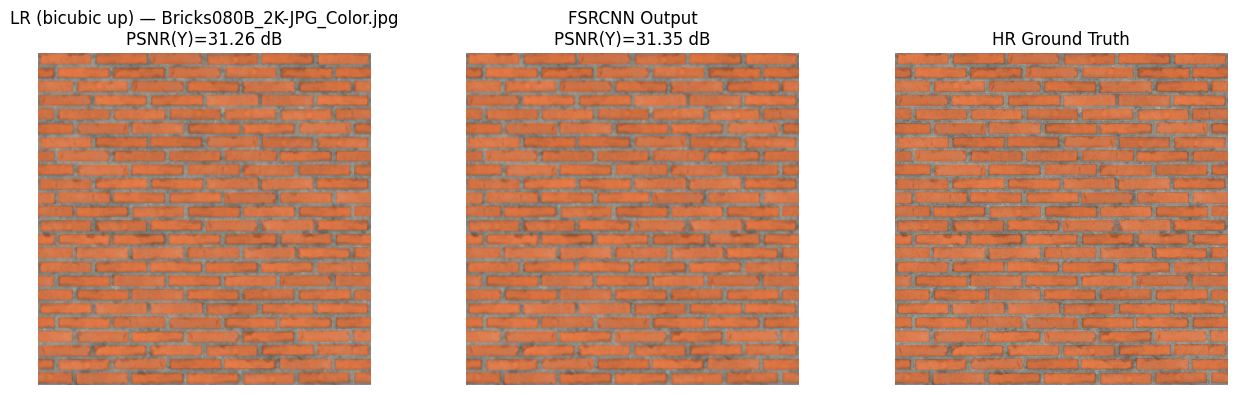

Saved:
   sr_outputs\Bricks080B_2K-JPG_Color_lr_bicubic.png
   sr_outputs\Bricks080B_2K-JPG_Color_fsrcnn.png
   sr_outputs\Bricks080B_2K-JPG_Color_hr.png


In [14]:
import torch.nn.functional as F

# For side-by-side viewing, show LR bicubic-upsampled to HR size
lr_up = F.interpolate(lr.unsqueeze(0), scale_factor=scale, mode="bilinear", align_corners=False).squeeze(0).clamp(0,1)

# --- Helpers for display & quick PSNR on Y channel ---
def to_hwc_np(t: torch.Tensor):
    return np.transpose(t.detach().cpu().numpy(), (1, 2, 0))

def rgb_to_y(t: torch.Tensor) -> torch.Tensor:
    r,g,b = t[0], t[1], t[2]
    return (0.299*r + 0.587*g + 0.114*b).unsqueeze(0)

def psnr(a: torch.Tensor, b: torch.Tensor, eps=1e-10):
    mse = torch.mean((a - b) ** 2).item()
    return 20.0 * math.log10(1.0 / math.sqrt(mse + eps))

psnr_bic = psnr(rgb_to_y(lr_up), rgb_to_y(hr))
psnr_sr  = psnr(rgb_to_y(sr),    rgb_to_y(hr))
print(f"PSNR(Y)  Bicubic: {psnr_bic:.2f} dB | FSRCNN: {psnr_sr:.2f} dB")

print("Shape: ", lr.shape)
print("Shape: ", to_hwc_np(lr).shape)

# --- Plot ---
fig, axes = plt.subplots(1, 3, figsize=(13, 4))
axes[0].imshow(to_hwc_np(lr)); axes[0].set_title(f"LR (bicubic up) — {name}\nPSNR(Y)={psnr_bic:.2f} dB")
axes[0].axis("off")
axes[1].imshow(to_hwc_np(sr));    axes[1].set_title(f"FSRCNN Output\nPSNR(Y)={psnr_sr:.2f} dB")
axes[1].axis("off")
axes[2].imshow(to_hwc_np(hr));    axes[2].set_title("HR Ground Truth")
axes[2].axis("off")
plt.tight_layout(); plt.show()

# --- Helpers to save tensors as PNG ---
def tensor_to_pil_rgb(t: torch.Tensor) -> Image.Image:
    """[3,H,W] or [1,H,W] float [0,1] -> PIL.Image"""
    t = t.detach().cpu().clamp(0, 1)
    if t.shape[0] == 1:
        arr = (t.squeeze(0).numpy() * 255.0 + 0.5).astype(np.uint8)   # H,W
        return Image.fromarray(arr, mode="L").convert("RGB")
    arr = (t.permute(1, 2, 0).numpy() * 255.0 + 0.5).astype(np.uint8) # H,W,3
    return Image.fromarray(arr, mode="RGB")

save_dir = "sr_outputs"
os.makedirs(save_dir, exist_ok=True)
stem = os.path.splitext(name)[0]

lr_path = os.path.join(save_dir, f"{stem}_lr_bicubic.png")
sr_path = os.path.join(save_dir, f"{stem}_fsrcnn.png")
hr_path = os.path.join(save_dir, f"{stem}_hr.png")

tensor_to_pil_rgb(lr_up).save(lr_path)
tensor_to_pil_rgb(sr).save(sr_path)
tensor_to_pil_rgb(hr).save(hr_path)

print("Saved:")
print("  ", lr_path)
print("  ", sr_path)
print("  ", hr_path)